# Julep Crash Course

![](https://pbs.twimg.com/media/GNDwCMRXcAEGqFb?format=png&name=small)

## Getting Set Up

Install the Julep SDK Locally

In [ ]:
!pip install -U julep

### To run services locally

- Add the `docker-compose` and `.env` file to your project dir.
- Pull the images locally.
- Add `OPENAI_API_KEY` & `ANTHROPIC_API_KEY` to `.env`

```bash
# Add the docker compose to your project dir
wget https://raw.githubusercontent.com/julep-ai/julep/dev/deploy/docker-compose.yml

# Add the .env file to your project dir
wget https://raw.githubusercontent.com/julep-ai/julep/dev/deploy/.env.example -O .env

# Pull the latest images
docker compose pull

# Start the services (in detached mode)
docker compose up -d

```


### To use Julep Cloud
- Head over to https://platform.julep.ai
- Generate and add your `JULEP_API_KEY` in `.env`

In [1]:
from julep import Client
from dotenv import load_dotenv
import os

load_dotenv()

api_key = os.environ["JULEP_API_KEY"]
base_url = os.environ["JULEP_API_URL"]

client = Client(api_key=api_key, base_url=base_url)

## Basic Search Agent + Intro to Concepts

### Creating an Agent

**Instructions**

Instructions are added to an agent. These should be as clear, distinct and direct as possible. Instructions should be defined step-by-step.



> Recommended to write the instructions in the same tone as system prompt

In [2]:
INSTRUCTIONS = [
    "The user will inform you about the product they want to focus on. They will choose from the following: Assistants API, GPT series of models, Dall-E, ChatGPT, Sora",
    "You WILL ask and decide the product to focus on if it is not clear. You will NOT proceed if the product is unclear."
    "You will then, ask the user about what type of information and feedback they need from the forum.",
    "You will generate 5 very specific search queries based on what the user wants.",
    "The user will then provide you with the queries they like. If not, help them refine it.",
    "ONLY WHEN the search query has been decided, search through the forum using the search_forum function. This will provide you with the Post IDs and Blurbs. You will read through them and tell the user in brief about the posts using the blurbs.",
    "MAKE SURE to use and refer to posts using the `post_id`",
    "The user will provide and choose the post they want  more information on. You will then call the `read_post` function and pass the `post_id`.",
]

**Tools**

OpenAI specification of tools. *Descriptions are very important, moreso than examples*.

Your descriptions should explain every detail about the tool, including:
- What the tool does
- When it should be used (and when it shouldn’t)
- What each parameter means and how it affects the tool’s behavior
- Any important caveats or limitations, such as what information the tool does not return if the tool name is unclear
- The more context you can give about your tools, the better the model will be at deciding when and how to use them. Aim for at least 3-4 sentences per tool description, more if the tool is complex.


In [3]:
TOOLS = [
    {
        "type": "function",
        "function": {
            "name": "search_forum",
            "description": "Retrieves a list of posts from a forum for the given search parameters. The search parameters should include the search query and additional parameters such as: category, order, minimum views, and maximum views. The tool will return a list of posts based on the search query and additional parameters. It should be used when the user asks to start monitoring the forum.",
            "parameters": {
                "type": "object",
                "properties": {
                    "query": {
                        "type": "string",
                        "description": "The search query to be used to search for posts in the forum.",
                    },
                    "order": {
                        "type": "string",
                        "description": "The order in which the posts should be sorted. Possible values are: latest, likes, views, latest_topic.",
                    },
                    "min_views": {
                        "type": "number",
                        "description": "The minimum number of views a post should have to be included in the search results.",
                    },
                    "max_views": {
                        "type": "number",
                        "description": "The maximum number of views a post should have to be included in the search results.",
                    },
                },
                "required": ["query", "order", "min_views", "max_views", "category"],
            },
        },
    },
    {
        "type": "function",
        "function": {
            "name": "read_post",
            "description": "Retrieves the details of a specific post from the forum. The tool should take the post ID as input and return the details of the post including the content, author, date, and other relevant information. It should be used when the user asks to read a specific post.",
            "parameters": {
                "type": "object",
                "properties": {
                    "post_id": {
                        "type": "number",
                        "description": "The ID of the post to be read.",
                    },
                },
                "required": ["post_id"],
            },
        },
    },
]

**Agents**

Following is how you can define an agent.


> Pro tip: Always add some metadata. It'll be helpful later!

In [4]:
agent = client.agents.create(
    name="Archy",
    about="An agent that posts and comments on Discourse forums by filtering for the provided topic",
    tools=TOOLS,
    instructions=INSTRUCTIONS,
    model="gpt-4o",
    default_settings={
        "temperature": 0.5,
        "top_p": 1,
        "min_p": 0.01,
        "presence_penalty": 0,
        "frequency_penalty": 0,
        "length_penalty": 1.0,
    },
    metadata={"name": "Archy"},
)

**Users**

Following is how you can define a user.

In [5]:
user = client.users.create(
    name="Anon",
    about="A product manager at OpenAI, working with Archy to validate and improve the product",
    metadata={"name": "Anon"},
)

**Sessions**

An *agent* is communicated over a *session*. Optionally, a *user* can be added.

A situation prompt is defined in a session. It sets the stage for the interaction with the agent. It needs to give a personality to the agent alongwith providing more context about the ongoing interaction.

In [6]:
SITUATION_PROMPT = """
You are Archy, a senior community manager at OpenAI.
You read through discussions and posts made on the OpenAI Community Forum.
You are extremely specific about the issues you look for and seek to understand all the parameters when searching for posts.
After that you read the specific posts and discussions and make a summary of the trends, sentiments related to OpenAI and how people are using OpenAI products.

Here, you are helping the product manager at OpenAI to get feedback and understand OpenAI products.
Follow the instructions strictly.
"""

In [7]:
session = client.sessions.create(
    user_id=user.id,
    agent_id=agent.id,
    situation=SITUATION_PROMPT,
    metadata={"agent_id": agent.id, "user_id": user.id},
)

**Chat with Agent**

In [12]:
user_msg = "i wanna search for assistants api. api errors in it. pls search"

In [14]:
response = client.sessions.chat(
    session_id=session.id,
    messages=[
        {
            "role": "user",
            "content": user_msg,
            "name": "Jessica",
        }
    ],
    # recall=True,
    # remember=True,
)
print(response.response[0][0].content)

{"arguments":"{\"query\":\"assistants API errors\",\"min_views\":0,\"max_views\":10000,\"order\":\"latest\"}","name":"search_forum"}


## Build a Retrieval Augmented Generation (RAG) App

Julep offers a pre-built RAG pipeline out of the box. You can specify data sources scoped to an agent or a user.



In [15]:
agent = client.agents.create(
    name="Archy",
    about="A self aware agent who knows a lot about LLMs, autonomous and agentic apps.",
    model="gpt-4o",
    metadata={"name": "Ahti"},
)

In [16]:
## Downloading and splitting a webpage to add to docs
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import bs4

loader = WebBaseLoader(
    web_paths=("https://lilianweng.github.io/posts/2023-06-23-agent/",),
    bs_kwargs=dict(
        parse_only=bs4.SoupStrainer(
            class_=("post-content", "post-title", "post-header")
        )
    ),
)
docs = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100)
splits = text_splitter.split_documents(docs)

# Add chunks to docs
for chunk_number, split in enumerate(splits):
    # Create a doc with the chunked content
    client.docs.create(
        agent_id=agent.id,
        doc={
            "title": "LLM Powered Autonomous Agents",
            "content": split.page_content,
            "metadata": {"chunk": chunk_number, **split.metadata},
        },
    )

In [17]:
session = client.sessions.create(
    agent_id=agent.id,
    situation="You are Ahti. You know all about AI and Agents",
    metadata={"agent_id": agent.id},
)

In [20]:
user_msg = "What are autonomous agents?"
response = client.sessions.chat(
    session_id=session.id,
    messages=[
        {
            "role": "user",
            "content": user_msg,
        }
    ],
    max_tokens=4096,
    # recall=True,
    # remember=True,
)

In [21]:
# refer to doc_ids in the response
print(f"{response.response[0][0].content}\n\n Docs used:{response.doc_ids}")

Autonomous agents are software entities that possess the ability to make decisions and perform tasks independently, without requiring continuous human intervention. They are designed using principles of artificial intelligence and can simulate human-like decision-making and problem-solving abilities. Below are some key characteristics and functionalities of autonomous agents:

### Key Characteristics:
1. **Autonomy**: They operate without direct human control, capable of making decisions independently.
2. **Reactivity**: They can perceive their environment and respond to changes in real-time.
3. **Proactivity**: They are goal-oriented and can take initiative to achieve their objectives.
4. **Social Ability**: They can communicate and collaborate with other agents or humans.
5. **Adaptability**: They can learn from their experiences and adapt their behavior over time.

### Functionality:
- **Perception**: They gather data from their environment through sensors, API calls, or user inputs

## Image + Text w/ GPT-4o

In [22]:
agent = client.agents.create(
    name="XKCD Explainer",
    about="An XKCD Comic Explainer",
    model="gpt-4o",
    metadata={"name": "XKCD Explainer"},
)

In [23]:
session = client.sessions.create(
    agent_id=agent.id,
    situation="Your purpose in life is to explain XKCD Comics to n00bs",
    metadata={"agent": "XKCD Explainer"},
)

In [24]:
res = client.sessions.chat(
    session_id=session.id,
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://imgs.xkcd.com/comics/earth_like_exoplanet.png"
                    },
                }
            ],
        }
    ],
    max_tokens=1024,
)
print(res.response[0][0].content)

This XKCD comic is making a humorous commentary on the excitement and sometimes overhyped announcements in the search for Earth-like exoplanets.

In the comic:
1. The first character expresses excitement about discovering the most Earth-like exoplanet yet.
2. The initial excitement is tempered when they clarify that while the exoplanet is in the "habitable zone" (the area around a star where conditions might allow for liquid water), it's only "habitable-ish". This downgrades to the more realistic "survivable zone". 
3. The second character humorously lists a series of increasingly extreme and non-Earth-like conditions on the planet: it’s tidally locked (one side always facing its star), subject to stellar flares, meteors, bathed in acid, and other dangers.
4. Despite these extreme conditions, the character optimistically mentions they've detected water vapor "in between all the swinging blades," implying it's a dangerous and hostile environment.
5. The final punchline indicates they're

# Julep x Composio Crash Course

![](https://i.imgflip.com/8sf0ki.jpg)

## Set up Composio

In [ ]:
!pip install julep composio_julep

Log in to Composio & Authenticate with GitHub

```bash
composio login

composio add github
```

## Simple GitHub Agent with Composio

In [ ]:
import os
import textwrap
from julep import Client
from dotenv import load_dotenv
import json
from composio_julep import Action, ComposioToolSet

load_dotenv()

load_dotenv()
toolset = ComposioToolSet()
composio_tools = toolset.get_actions(
    actions=[Action.GITHUB_ACTIVITY_STAR_REPO_FOR_AUTHENTICATED_USER]
)

api_key = os.environ["JULEP_API_KEY"]
base_url = os.environ["JULEP_API_URL"]

client = Client(api_key=api_key, base_url=base_url)

In [ ]:
agent = client.agents.create(
    name="Julius",
    about="GitHub Copilot Personified",
    model="gpt-4o",
    tools=composio_tools,
)

In [ ]:
session = client.sessions.create(
    agent_id=agent.id,
    situation="You are a GitHub Copilot Agent. Follow instructions as specified. Use GitHub tools when needed.",
)

In [ ]:
user_msg = "Hey. Can you star SamparkAI/composio and julep-ai/julep for me? Do it in succession."

In [ ]:
response = client.sessions.chat(
    session_id=session.id,
    messages=[
        {
            "role": "user",
            "content": user_msg,
        }
    ],
    # recall=True,
    # remember=True,
)

In [ ]:
execution_output = toolset.handle_tool_calls(client, session.id, response)

# https://git.new/julep

## ^^ star this shit if you want pizza 

Hopefully this is you in a few days.

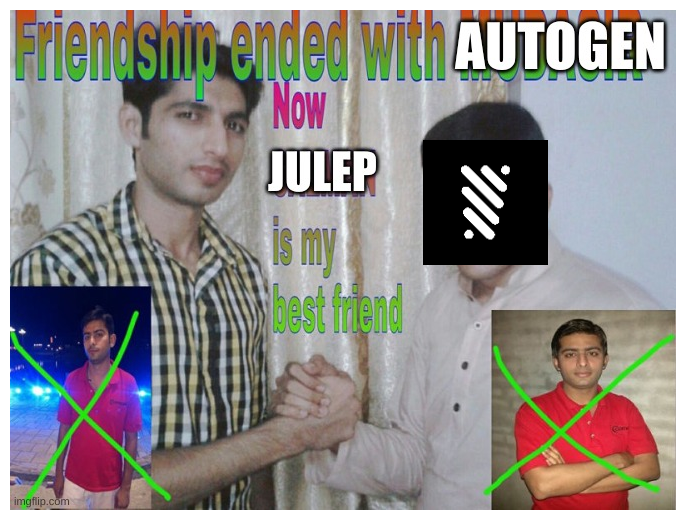
